In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
import matplotlib.cm as cm
from collections import defaultdict
import networkx as nx
import random
from collections import Counter
from datetime import datetime as dt
from os import listdir
from collections import defaultdict
import statsmodels.api as sm
from scipy.optimize import curve_fit

### functions

In [2]:
# flow functions
def flowDistanceFromSource(G): #input a balanced nx graph
    R = G.reverse()
    mapping = {'source':'sink','sink':'source'} 
    H = nx.relabel_nodes(R,mapping)
    #---------initialize flow distance dict------
    L = dict((i,1) for i in G.nodes())
    #---------prepare weighted out-degree dict------
    T = G.out_degree(weight='weight')
    #---------iterate until converge------------
    ls = np.array(L.values())
    delta = len(L)*0.01 + 1
    k=0
    while delta > len(L)*0.01:
        k+=1
        if k>20:
            break
        for i in L:
            l=1
            for m,n in H.edges(i):
                l+=L[n]*H[m][n].values()[0]/float(T[m])
            L[i]=l
        delta = sum(np.abs(np.array(L.values()) - ls))
        ls = np.array(L.values())
    #---------clean the result-------
    del L['sink']
    for i in L:
        L[i]-=1
    L['sink'] = L.pop('source')
    return L

def flowBalancing(G):
    RG = G.reverse()
    H = G.copy()
    def nodeBalancing(node):
        outw=0
        for i in G.edges(node):
            outw+=G[i[0]][i[1]].values()[0]
        inw=0
        for i in RG.edges(node):
            inw+=RG[i[0]][i[1]].values()[0]
        deltaflow=inw-outw
        if deltaflow > 0:
            H.add_edge(node, "sink",weight=deltaflow)
        elif deltaflow < 0:
            H.add_edge("source", node, weight=abs(deltaflow))
        else:
            pass
    for i in G.nodes():
        nodeBalancing(i)
    if ("source", "source") in H.edges():  H.remove_edge("source", "source")    
    if ("sink", "sink") in H.edges(): H.remove_edge("sink", "sink")
    return H

def WebtoTree(G):
    H = flowBalancing(G)
    T = H.out_degree(weight='weight')
    R = H.reverse()
    L = flowDistanceFromSource(H)
    L['source']=0
    S=defaultdict(lambda:[])
    for i in H.nodes():
        if i!='source':
            es=R[i]
            w,k=sorted([(es[j]['weight'],j) for j in es],reverse=True)[0]
            S[k].append(i)
    return H,T,L,S



def circle(r):
    radius = r
    angle = random.uniform(0, 2*np.pi)
    return [radius*np.sin(angle), radius*np.cos(angle)]


def flushPrint(s):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % s)
    sys.stdout.flush()


#Tree ploting functions
# from http://billmill.org/pymag-trees/

class Tree:
    def __init__(self, node="", *children):
        self.node = node
        self.width = len(node)
        if children: self.children = children
        else:        self.children = []
    def __str__(self): 
        return "%s" % (self.node)
    def __repr__(self):
        return "%s" % (self.node)
    def __getitem__(self, key):
        if isinstance(key, int) or isinstance(key, slice): 
            return self.children[key]
        if isinstance(key, str):
            for child in self.children:
                if child.node == key: return child
    def __iter__(self): return self.children.__iter__()
    def __len__(self): return len(self.children)
    def addChild(self,nodeName): self.children.append(nodeName)

class DrawTree(object):
    def __init__(self, tree, parent=None, depth=0, number=1):
        self.x = -1.
        self.y = depth
        self.tree = tree
        self.children = [DrawTree(c, self, depth+1, i+1) 
                         for i, c
                         in enumerate(tree.children)]
        self.parent = parent
        self.thread = None
        self.mod = 0
        self.ancestor = self
        self.change = self.shift = 0
        self._lmost_sibling = None
        #this is the number of the node in its group of siblings 1..n
        self.number = number

    def left(self): 
        return self.thread or len(self.children) and self.children[0]

    def right(self):
        return self.thread or len(self.children) and self.children[-1]

    def lbrother(self):
        n = None
        if self.parent:
            for node in self.parent.children:
                if node == self: return n
                else:            n = node
        return n

    def get_lmost_sibling(self):
        if not self._lmost_sibling and self.parent and self != \
        self.parent.children[0]:
            self._lmost_sibling = self.parent.children[0]
        return self._lmost_sibling
    lmost_sibling = property(get_lmost_sibling)

    def __str__(self): return "%s: x=%s mod=%s" % (self.tree, self.x, self.mod)
    def __repr__(self): return self.__str__()        
        
def buchheim(tree):
    dt = firstwalk(DrawTree(tree))
    min = second_walk(dt)
    if min < 0:
        third_walk(dt, -min)
    return dt

def third_walk(tree, n):
    tree.x += n
    for c in tree.children:
        third_walk(c, n)

def firstwalk(v, distance=1.):
    if len(v.children) == 0:
        if v.lmost_sibling:
            v.x = v.lbrother().x + distance
        else:
            v.x = 0.
    else:
        default_ancestor = v.children[0]
        for w in v.children:
            firstwalk(w)
            default_ancestor = apportion(w, default_ancestor, distance)
        #print "finished v =", v.tree, "children"
        execute_shifts(v)

        midpoint = (v.children[0].x + v.children[-1].x) / 2

        ell = v.children[0]
        arr = v.children[-1]
        w = v.lbrother()
        if w:
            v.x = w.x + distance
            v.mod = v.x - midpoint
        else:
            v.x = midpoint
    return v

def apportion(v, default_ancestor, distance):
    w = v.lbrother()
    if w is not None:
        #in buchheim notation:
        #i == inner; o == outer; r == right; l == left; r = +; l = -
        vir = vor = v
        vil = w
        vol = v.lmost_sibling
        sir = sor = v.mod
        sil = vil.mod
        sol = vol.mod
        while vil.right() and vir.left():
            vil = vil.right()
            vir = vir.left()
            vol = vol.left()
            vor = vor.right()
            vor.ancestor = v
            shift = (vil.x + sil) - (vir.x + sir) + distance
            if shift > 0:
                move_subtree(ancestor(vil, v, default_ancestor), v, shift)
                sir = sir + shift
                sor = sor + shift
            sil += vil.mod
            sir += vir.mod
            sol += vol.mod
            sor += vor.mod
        if vil.right() and not vor.right():
            vor.thread = vil.right()
            vor.mod += sil - sor
        else:
            if vir.left() and not vol.left():
                vol.thread = vir.left()
                vol.mod += sir - sol
            default_ancestor = v
    return default_ancestor

def move_subtree(wl, wr, shift):
    subtrees = wr.number - wl.number
    #print wl.tree, "is conflicted with", wr.tree, 'moving', subtrees, 'shift', shift
    #print wl, wr, wr.number, wl.number, shift, subtrees, shift/subtrees
    wr.change -= shift / subtrees
    wr.shift += shift
    wl.change += shift / subtrees
    wr.x += shift
    wr.mod += shift

def execute_shifts(v):
    shift = change = 0
    for w in v.children[::-1]:
        #print "shift:", w, shift, w.change
        w.x += shift
        w.mod += shift
        change += w.change
        shift += w.shift + change

def ancestor(vil, v, default_ancestor):
    #the relevant text is at the bottom of page 7 of
    #"Improving Walker's Algorithm to Run in Linear Time" by Buchheim et al, (2002)
    #http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.16.8757&rep=rep1&type=pdf
    if vil.ancestor in v.parent.children:
        return vil.ancestor
    else:
        return default_ancestor

def second_walk(v, m=0, depth=0, min=None):
    v.x += m
    v.y = depth

    if min is None or v.x < min:
        min = v.x

    for w in v.children:
        min = second_walk(w, m + v.mod, depth+1, min)

    return min

def generateTree(edgeDic):
    allNodes={}
    for k,v in edgeDic.items():
        if k in allNodes:
            n=allNodes[k]
        else:
            n=Tree(k,)
            allNodes[k]=n
        for s in v:
            if s in allNodes:
                cn=allNodes[s]
            else:
                cn=Tree(s,)
                allNodes[s]=cn
            allNodes[k].addChild(cn)
    return allNodes

def width(apex,xm=0):
    if not apex.children:
        return xm
    for child in apex.children:
        if child.x > xm:
            xm = child.x
            #print xm
        xm = width(child,xm)
    return xm

def depth(root,node,h=0):
    if str(root.tree)==str(node):
        h= root.y
    else:
        for i in root.children:
            h = depth(i,node,h)
    return h

def angleCo(x,y,xm,ym):
    angle=2*ym*np.pi*x/(xm+1)
    nx,ny=y*np.sin(angle), y*np.cos(angle)
    return nx,ny

def drawt(ax,root,rawVersion,circle,J,U,max_x,max_y):
    x=root.x
    if rawVersion==True:
        y=root.y
    else:
        y=J[str(root.tree)]
    if circle == True:
        x,y=angleCo(x,y,max_x,max_y)
    if str(root.tree)!='source':
        ax.scatter(x, y, facecolor='c',lw = 0,alpha=1,
                    s=200*U[str(root.tree)]/max(U.values())+3,zorder=2)
    for child in root.children:
        drawt(ax,child,rawVersion,circle,J,U,max_x,max_y)

def drawconn(ax,root,rawVersion,circle,J,max_x,max_y):
    rootx=root.x
    if rawVersion==True:
        rooty=root.y
    else:
        rooty=J[str(root.tree)]
    if circle == True:
        rootx,rooty=angleCo(rootx,rooty,max_x,max_y)
    for child in root.children: 
        childx=child.x
        if rawVersion==True:
            childy=child.y
        else:
            childy=J[str(child.tree)]
        if circle == True:
            childx,childy=angleCo(childx,childy,max_x,max_y)
        '''
        plt.plot([rootx, childx],[rooty,childy],linestyle='-',
                 linewidth=0.1,color='grey',alpha=0.2,zorder=1)
        '''
        ax.annotate('',
            xy=(childx, childy), xycoords='data',
            xytext=(rootx, rooty), textcoords='data',
            size=5, va="center", ha="center",zorder=1,
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3,rad=-0.2",fc='white',
                            ec='white',alpha=0.5), 
            )
        drawconn(ax,child,rawVersion,circle,J,max_x,max_y)

### 2. Example flow trees

In [41]:
G=nx.DiGraph()
G.add_edge('source',1,weight=80)
G.add_edge(1,2,weight=50)
G.add_edge(1,3,weight=30)
G.add_edge(3,2,weight=10)
G.add_edge(2,4,weight=20)
G.add_edge(2,5,weight=30)
G.add_edge(4,5,weight=10)
G.add_edge(5,3,weight=5)
G.add_edge(2,'sink',weight=10)
G.add_edge(4,'sink',weight=10)
G.add_edge(3,'sink',weight=25)
G.add_edge(5,'sink',weight=35)

In [54]:
def plotTree(G,ax):
    H,T,L,S=WebtoTree(G)
    V={str(k):map(str,v) for k,v in S.items()}
    treeDic=generateTree(V)
    tree=treeDic['source']
    d = buchheim(tree)
    J={str(k):v for k,v in L.items()}
    U={str(k):v for k,v in T.items()}
    max_y=depth(d,max(L, key=L.get))
    max_x=width(d)
    ax.set_axis_bgcolor('#1f2838')
    drawconn(ax,d,False,False,J,max_x,max_y)
    drawt(ax,d,False,False,J,U,max_x,max_y)

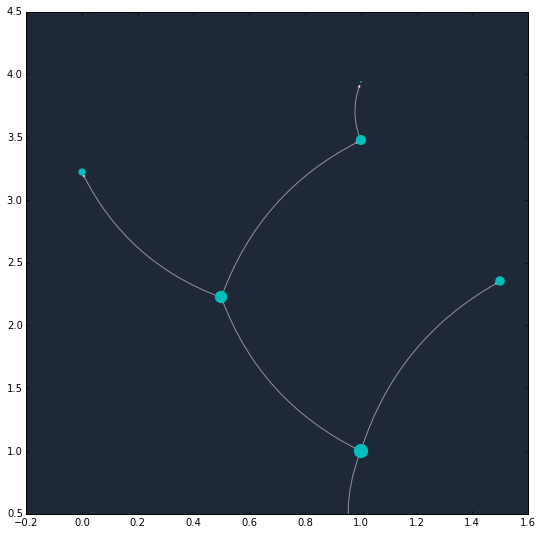

In [55]:
fig = plt.figure(figsize=(9, 9),facecolor='white')
ax = fig.add_subplot(111)
plotTree(G,ax)
plt.show()